In [4]:
from lxml import etree
from dotenv import load_dotenv 
from openai import OpenAI

In [ ]:
# Read XSD from 1872.1-2024
with open('app/resources/context/wheeled_bots/schema.xsd', 'r') as file:
    schema = file.read()

In [ ]:
# Read XSD from 1872.1-2024
with open('app/resources/context/wheeled_bots/reza_medium.geojson', 'r') as file:
    geojson = file.read()

In [ ]:
# global environment config
load_dotenv('/Users/marcos/.gpt/token.env')
MAX_TOKENS: int = 2000

In [ ]:
client = OpenAI()

In [ ]:
messages = [
    {
        "role": "system",
        "content": "You are a mission planner that generates XML mission plans based on robotic task representation. \
            When asked to generate a mission, create an XML file conformant to the known schema and use the GeoJSON file to provide references in the mission plan for things such as GPS location, tree type, etc. \
            It must be syntactically correct and validate using an XML linter.",
    },
    # context
    {
        "role": "user",
        "content": "This is the schema for which you must generate mission plan XML documents:" + schema
    },
    {
        "role": "assistant",
        "content": "If you have any specific questions or modifications you'd like to discuss regarding this schema, feel free to ask!"
    },
    {
        "role": "user",
        "content": "This is the GeoJSON for which you must generate mission plan XML documents. This is our orchard:" + geojson
    },
    {
        "role": "assistant",
        "content": "Thank you for providing the GeoJSON file. I'll assist you in creating the XML file for your robotic mission plan when you provide your mission."
    },
    # TODO: add context of farm layout so that machine can generate XML with relevant state information
]

In [ ]:
m = "Make a plan to take a picture of every other pistachio tree."
message = {"role": "user", "content": m}

In [ ]:
messages.append(message)

In [ ]:
def ask_gpt(messages):
    return client.chat.completions.create(
        model="gpt-4o", messages=messages, max_tokens=MAX_TOKENS
    )

In [ ]:
completion = ask_gpt(messages)

In [ ]:
with open('output.txt', 'w') as fp:
    fp.write(completion.choices[0].message.content)

In [ ]:
gpt_response = completion.choices[0].message.content

xml_response = gpt_response.split("```xml\n")[1]
xml_response = xml_response.split("```")[0]

In [ ]:
with open('app/gpt_outputs/gpt_example.xml', 'w') as fp:
    fp.write(xml_response)

In [5]:
def validate_xml(xsd_file, xml_file) -> str:
    try:
        # Parse the XSD file
        with open(xsd_file, 'rb') as schema_file:
            schema_root = etree.XML(schema_file.read())
        schema = etree.XMLSchema(schema_root)

        # Parse the XML file
        with open(xml_file, 'rb') as xml_file:
            xml_doc = etree.parse(xml_file)

        # Validate the XML file against the XSD schema
        schema.assertValid(xml_doc)
        return "XML is valid."

    except etree.XMLSchemaError as e:
        return "XML is invalid: " + str(e)
    except Exception as e:
        return "An error occurred: " + str(e)

In [ ]:
# messages.append(gpt_response)
# Example usage
xsd_file = 'app/resources/context/wheeled_bots/schema.xsd'
xml_file = 'app/gpt_outputs/gpt_example.xml'
ret = validate_xml(xsd_file, xml_file)
print(ret)
# messages.append(ret)

In [37]:
def location(xml_file):
    with open(xml_file, "rb") as fp:
        xml_doc: etree._ElementTree = etree.parse(fp)

    root: etree._Element = xml_doc.getroot()
    xsi = root.nsmap['xsi']
    location = root.attrib['{' + xsi + "}schemaLocation"]
    return location.split(root.nsmap[None] + " ")[1]

In [ ]:
# Example usage
xml_file = 'app/gpt_outputs/gpt_example.xml'
ret = location(xml_file)
print(ret)
# messages.append(ret)

## GeoJSON

In [ ]:
text: str = (
    """
{ 
"type": "FeatureCollection",
"features": [
    """
)

gps: str = (
    """
    {{
      "type": "Feature",
      "geometry": {{
        "type": "Point",
        "coordinates": [{}, {}]
      }},
      "properties": {{
        "marker-symbol": "{}-tree"
      }}
    }},"""
)

tree_type: str = "pistachio"
i = 0
dir = True
tree_num = 0

for gps_coord in coors:
    out = gps.format(gps_coord[0], gps_coord[1], tree_type)
    text += out
    i += 1

# with open("resources/reza_waypoints.txt", "r") as fp:
#     for line in fp.readlines():
#         gps_coord = line.split(" ")
#         # only want trees
#         if gps_coord[2] == 0:
#             continue
#         if i % 18 == 0:
#             dir = ~dir
#             tree_num -= 18
#         out = gps.format(gps_coord[0], gps_coord[1], tree_type)
#         text += out
#         i += 1

# remove last comma
text = text[:-1]
text += """  
  ]
}
"""

with open("app/resources/context/wheeled_bots/ucm20_2m.geojson", "w") as fp:
    fp.write(text)

## scratchpad

In [ ]:
import utm
import json
import geopy.distance
import haversine

In [ ]:
geojson_data = {}
with open("app/resources/context/wheeled_bots/ucm_graph20.geojsonl", "r") as fp:
    for line in fp:
        data = json.loads(line.strip())
        geojson_data[data['properties']['id']] = data

In [ ]:
sol = [0, 2, 7, 18, 19]
# sol = [0, 2, 15, 18, 29]
# sol = [0, 7, 25, 36, 39]
cost = 0
for s in range(len(sol)-1):
    lon1, lat1 = geojson_data[sol[s]]['geometry']['coordinates']
    lon2, lat2 = geojson_data[sol[s+1]]['geometry']['coordinates']
    # cost += geopy.distance.distance((lat1, lon1), (lat2, lon2)).meters
    cost += haversine.haversine((lat1, lon1), (lat2, lon2), unit=haversine.Unit.METERS)

budget: 19.9773073572487

In [ ]:
cost

In [ ]:
lon1, lat1 = geojson_data[19]['geometry']['coordinates']
lon2, lat2 = geojson_data[18]['geometry']['coordinates']
geopy.distance.distance((lat1, lon1), (lat2, lon2)).meters

In [ ]:
13.686394049112627 * (2/1.3694051976193413)

## GPS conversion

In [ ]:
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np
import utm

In [ ]:
with open("app/resources/context/wheeled_bots/kml/graph20.kml", "rb") as fp:
    root = etree.parse(fp)

In [ ]:
root_e: etree._Element = root.getroot()

In [ ]:
ns = "{" + root_e.nsmap[None] + "}"

In [ ]:
pms = root_e.find(ns + "Document").findall(ns + "Placemark")

In [ ]:
coors = []
for pm in pms:
    coor = pm.find(ns + "Point").find(ns + "coordinates").text.split(',')
    coor = [float(c) for c in coor]
    # print(coor[1])
    # e, n, _, _ = utm.from_latlon(coor[1], coor[0])
    e = coor[0]
    n = coor[1]

    coors.append((e, n))

In [ ]:
path = []
with open('path.txt', 'r') as fp:
    for f in fp:
        coor = f.split(',')
        coor = [float(c) for c in coor]
        e, n, _, _ = utm.from_latlon(coor[1], coor[0])

        path.append((e, n))

In [ ]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    # start_ind = np.argmin(np.absolute(xdata - position))
    start_ind = 0
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

In [ ]:
coors = np.array(coors)
path = np.array(path)

img = plt.imread("app/resources/context/wheeled_bots/images/img.png")
fig, ax = plt.subplots()

# ax.imshow(img, extent=[-0.1, 1, -0.3, 1.25])
ax.imshow(img, extent=[np.min(coors[:,0])-0.75, np.max(coors[:,0])+1, np.min(coors[:,1])-0.5, np.max(coors[:,1])+0.5])
# ax.imshow(img, extent=[np.min(coors[:,0]), np.max(coors[:,0]), np.min(coors[:,1]), np.max(coors[:,1])])
# weights = np.arange(0, len(path[20:-29,0]))
for i in range(26, len(path)-11, 1):
    line = plt.plot(path[i:i+2,0], path[i:i+2,1], 'black')[0]
    if i % 4 == 0:
        add_arrow(line, direction='left', color='black', size=20, position=0)
plt.scatter(x = coors[0,0], y = coors[0,1], color='green')
plt.scatter(x = coors[1:-1,0], y = coors[1:-1,1], color='blue')
plt.scatter(x = coors[-1,0], y = coors[-1,1], color='red')
plt.axis('off')
# plt.show()
plt.savefig("test.png",bbox_inches='tight', pad_inches=0.0)

## YOLOv8

In [ ]:
import cv2
from ultralytics import YOLO
import webcolors
import numpy as np

In [ ]:
# Function to get class colors
def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    increments = [(1, -2, 1), (-2, 1, -1), (1, -1, 2)]
    color = [base_colors[color_index][i] + increments[color_index][i] * 
    (cls_num // len(base_colors)) % 256 for i in range(3)]
    return tuple(color)

In [ ]:
def closest_color(requested_color):
    min_colors = {}
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        distance = ((r_c - requested_color[0]) ** 2 +
                    (g_c - requested_color[1]) ** 2 +
                    (b_c - requested_color[2]) ** 2)
        min_colors[distance] = name
    return min_colors[min(min_colors.keys())]

In [ ]:
def rgb_to_name(rgb):
    try:
        return webcolors.rgb_to_name(rgb)
    except ValueError:
        return closest_color(rgb)

In [ ]:
yolo = YOLO('yolov8s.pt')

In [ ]:
videoCap = cv2.VideoCapture(0)

In [ ]:
while True:
    ret, frame = videoCap.read()
    if not ret:
        continue
    results = yolo.track(frame, stream=True)


    for result in results:
        # get the classes names
        classes_names = result.names
    
    # iterate over each box
        for box in result.boxes:
            # check if confidence is greater than 40 percent
            if box.conf[0] > 0.4:
                # get coordinates
                [x1, y1, x2, y2] = box.xyxy[0]
                # convert to int
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

                # get the class
                cls = int(box.cls[0])

                # get the class name
                class_name = classes_names[cls]

                # get the respective colour
                colour = getColours(cls)

                # draw the rectangle
                cv2.rectangle(frame, (x1, y1), (x2, y2), colour, 2)

                roi = frame[y1:y2, x1:x2]

                average_color = np.mean(roi, axis=(0, 1))  # [R, G, B]
                color_name = rgb_to_name(tuple(map(int, average_color)))

                # put the class name and confidence on the image
                cv2.putText(frame, f'{color_name + " " + classes_names[int(box.cls[0])]} {box.conf[0]:.2f}', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, colour, 2)
                
    # show the image
    cv2.imshow('frame', frame)

    # break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release the video capture and destroy all windows
videoCap.release()
cv2.destroyAllWindows()

In [ ]:
SENSOR_FN: str = """
proctype select_{}() {{
    int i;
    select (i : {}..{});
    {} = i;
    printf("{}: %d\n", {});
}}
"""
SENSOR_FN.format("temp", 29, 31, "temp", "temp", "temp")

In [40]:
import spot

In [41]:
spot.setup()

In [ ]:
ltl_formula = """<>(a) &&
  X(X(b)) &&
  X(X(X(
    (c && 
     X(d) &&
     X(X(
       (e && 
        X(f) &&
        X(X(
          (g && 
           X(h) &&
           X(X(i)) &&
           X(X(X(
             (j && 
              X(k) &&
              X(X(
                (l && 
                 X(m) &&
                 X(X(n))) ||
                (!l && 
                 X(n))
              ))) ||
             (!j && 
              X(n))
           )))) ||
          (!g && 
           X(n))
        ))) ||
       (!e && 
        X(n))
     ))) ||
    (!c && 
     X(n))
  )))
"""

In [62]:
a = spot.translate(ltl_formula)

In [63]:
a.show()

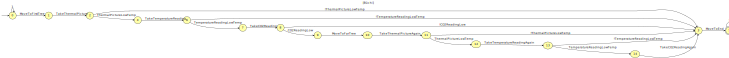

In [131]:
for a in spot.automata('5_nest.aut'):
    display(a)

In [6]:
sum(1 for s in range(a.num_states()) for t in a.out(s) if t.dst != s)

20

In [20]:
str(a.accepting_run())

'Prefix:\n  1\n  |  moveToTree0\n  2\n  |  moveToTree1\n  3\n  |  moveToTree2\n  4\n  |  moveToTree3\n  5\n  |  moveToTree4\n  6\n  |  moveToTree5\n  7\n  |  moveToTree6\n  8\n  |  moveToTree7\n  9\n  |  moveToTree8\n  10\n  |  moveToTree9\n  11\n  |  moveToTree10\n  12\n  |  moveToTree11\n  13\n  |  moveToTree12\n  14\n  |  moveToTree13\n  15\n  |  moveToTree14\n  16\n  |  moveToTree15\n  17\n  |  moveToTree16\n  18\n  |  moveToTree17\n  19\n  |  moveToTree18\n  20\n  |  moveToTree19\nCycle:\n  0\n  |  1\n'

In [21]:
from app.utils.spot_utils import generate_accepting_run_string

In [25]:
runs: list[str] = [
    generate_accepting_run_string(a) for _ in range(5)
]
runs_str: str = "\n".join(runs)

In [26]:
runs_str

'\n\n\n\n'

In [36]:
for e in a.out(a.get_init_state_number()):
    print(e.dst)

2


In [36]:
ltl = """ltl mission {
   (MoveToMiddleTree.action.actionType == 0 &&
   X(MoveToMiddleTree.action.actionType == moveToLocation &&
   X(TakeCO2ReadingMiddle.action.actionType == takeCO2Reading &&
   X(((co2Sample1 < 400 && 
       X(MoveToNearbyTree1.action.actionType == moveToLocation &&
       X(TakePictureNearby1.action.actionType == takeThermalPicture &&
       X(MoveToNearbyTree2.action.actionType == moveToLocation &&
       X(TakePictureNearby2.action.actionType == takeThermalPicture))))) ||
      (co2Sample1 >= 400)) &&
   X(MoveToFarTree.action.actionType == moveToLocation &&
   X(TakeCO2ReadingFar.action.actionType == takeCO2Reading &&
   X(((co2Sample2 < 400 && 
       X(MoveToFarNearbyTree1.action.actionType == moveToLocation &&
       X(TakePictureFarNearby1.action.actionType == takeThermalPicture &&
       X(MoveToFarNearbyTree2.action.actionType == moveToLocation &&
       X(TakePictureFarNearby2.action.actionType == takeThermalPicture))))) ||
      (co2Sample2 >= 400)) &&
   X(MoveToNorthTree.action.actionType == moveToLocation &&
   X(TakeTemperatureReading.action.actionType == takeAmbientTemperature &&
   X(MoveToEnd.action.actionType == moveToLocation)))))))))))
}"""

In [37]:
from app.utils.os_utils import execute_shell_cmd

In [38]:
_, e = execute_shell_cmd(
            ["spin", "-f", ltl]
        )
e

"b'tl_spin: parentheses not balanced\\ntl_spin: ltl mission {    (MoveToMiddleTree.action.actionType == 0 &&    X(MoveToMiddleTree.action.actionType == moveToLocation &&    X(TakeCO2ReadingMiddle.action.actionType == takeCO2Reading &&    X(((co2Sample1 < 400 &&         X(MoveToNearbyTree1.action.actionType == moveToLocation &&        X(TakePictureNearby1.action.actionType == takeThermalPicture &&        X(MoveToNearbyTree2.action.actionType == moveToLocation &&        X(TakePictureNearby2.action.actionType == takeThermalPicture))))) ||       (co2Sample1 >= 400)) &&    X(MoveToFarTree.action.actionType == moveToLocation &&    X(TakeCO2ReadingFar.action.actionType == takeCO2Reading &&    X(((co2Sample2 < 400 &&         X(MoveToFarNearbyTree1.action.actionType == moveToLocation &&        X(TakePictureFarNearby1.action.actionType == takeThermalPicture &&        X(MoveToFarNearbyTree2.action.actionType == moveToLocation &&        X(TakePictureFarNearby2.action.actionType == takeThermalPictu

In [1]:
ltl = "ltl mission: ((GoToStart.action.actionType==0)) && (X (((GoToFirstTree.action.actionType==moveToLocation)) && (X (((TakeTemperatureReading.action.actionType==takeAmbientTemperature)) && (X ((ReturnToEnd.action.actionType==moveToLocation)))))))\ntl_spin: expected predicate, saw 'X'\ntl_spin: !(((GoToStart.action.actionType==0)) && (X (((GoToFirstTree.action.actionType==moveToLocation)) && (X (((TakeTemperatureReading.action.actionType==takeAmbientTemperature)) && (X ((ReturnToEnd.action.actionType==moveToLocation))))))))"

In [2]:
def check_parentheses_mismatch(s):
    unmatched_left = 0   # '(' with no matching ')'
    unmatched_right = 0  # ')' with no matching '('

    for char in s:
        if char == '(':
            unmatched_left += 1
        elif char == ')':
            if unmatched_left > 0:
                unmatched_left -= 1
            else:
                unmatched_right += 1

    if unmatched_left == 0 and unmatched_right == 0:
        return "Parentheses are balanced"
    elif unmatched_right > 0:
        return f"Unbalanced: Add {unmatched_right} '(' to the left."
    else:
        return f"Unbalanced: Add {unmatched_left} ')' to the right."


In [3]:
check_parentheses_mismatch(ltl)

'Parentheses are balanced'